In [17]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, pearsonr, ttest_ind
from scipy.special import rel_entr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

figsize=(15,12)
fontsize = 45
export_dir = './plots_seed/'
load_dir = './data_tournament/'
filetype = 'pdf'

env_name = ['chicken', 'pure_coordination', 'prisoners_dilemma', 'stag_hunt']
row_name = ['S', 'M', 'L', 'O']
col_name = ['SP5', 'PP3', 'PP5']

row_name_dict = {'S': 'Small',
                 'M': 'Medium',
                 'L': 'Large',
                 'O': 'Obstacle'}

col_name_dict = {'SP5': 'SP',
                 'PP3': 'PP 3 Seeds',
                 'PP5': 'PP 5 Seeds',
                 'FCP3': 'FCP 3 Seeds',
                 'FCP5': 'FCP 5 Seeds'}
env_name_dict = {'chicken': 'Chicken',
                 'pure_coordination': 'Pure\nCoordination',
                 'prisoners_dilemma': 'Prisoners\nDilemma',
                 'stag_hunt': 'Stag\nHunt'}

sns.set()
sns.set_context("paper")
sns.set(rc={'figure.figsize':figsize})
sns.set_style("whitegrid")
palette = ["#FFBE7A", "#FA7F6F", "#82B0D2", "#BEB8DC"]
palette_2 = ["#f8ac8c", "#9ac9db", "#2878b5"]

In [18]:
rewards = np.empty((len(row_name), len(col_name), 2)) # mean & variance
raw_df = pd.DataFrame()
for env in np.arange(len(env_name)):
    for row in np.arange(len(row_name)):
        for col in np.arange(len(col_name)):
            loaded = np.load(os.path.join(load_dir,env_name[env]+'_'+row_name[row]+'_'+col_name[col]+'.npz'))
            # print(np.shape(loaded['rewards']))
            current_reward = np.mean(loaded['rewards'], axis=1).flatten()
            temp_df = pd.DataFrame({'rewards': current_reward, 
                                    'config': np.repeat(row_name_dict[row_name[row]], len(current_reward)),
                                    'method': np.repeat(col_name_dict[col_name[col]], len(current_reward)),
                                    'env': np.repeat(env_name[env], len(current_reward))})
            raw_df = raw_df._append(temp_df, ignore_index=True)
raw_df

,rewards,config,method,env
0,75.353214,Small,SP,chicken
1,72.685714,Small,SP,chicken
2,83.537659,Small,SP,chicken
3,75.075959,Small,SP,chicken
4,75.953361,Small,SP,chicken
...,...,...,...,...
2875,54.610093,Obstacle,PP 5 Seeds,stag_hunt
2876,47.114800,Obstacle,PP 5 Seeds,stag_hunt
2877,51.559246,Obstacle,PP 5 Seeds,stag_hunt
2878,49.415450,Obstacle,PP 5 Seeds,stag_hunt


In [19]:
method_dict = {} # 'env': # seed x # samples x configs
index_df = pd.DataFrame()

for env in env_name:
    env_name_list = [f'{env}_{_}' for _ in row_name]
    load_dir_list = [f'./data_index/{_}_5M_2.npz' for _ in env_name_list]
    if env == 'pure_coordination':
        load_dir_list = [f'./data_index/{_}_5M.npz' for _ in env_name_list]

    print(f'{env}')

    seeds_list_dict = {
        '1 Bob': ([0],[1],[2],[3],[4]),
        '2 Bobs': ([0,2],[1,2],[2,3],[3,4],[0,4]),
        '3 Bobs': ([1,2,4],[2,3,4],[0,1,3],[0,2,4],[0,1,3]),
        '4 Bobs': ([1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3])
    }

    method_seed = []

    for seeds_num in seeds_list_dict:
        seeds_list = seeds_list_dict[seeds_num]
        total_index = np.empty([5,4])
        seed_num = 0
        
        method_combo = []

        for seeds in seeds_list:
            
            index = []
            method = []

            for load_dir in load_dir_list:
                loaded = np.load(load_dir)
                rewards = loaded['rewards']
                checkpoints = loaded['checkpoints']
                rewards = rewards[0,...] # only have 1 evaluation seed
                mean_rewards = np.mean(rewards,axis=0)
                # np.shape(mean_rewards)
                index_list = []
                for seed in seeds:
                    current_seed_list = []
                    for eval_gen in range(np.shape(rewards)[0]):
                        row_rewards = rewards[eval_gen,seed,:,:,0]
                        col_rewards = rewards[eval_gen,seed,:,:,1]
                        # start = np.min(row_rewards)
                        # end = np.max(row_rewards)
                        start = 0
                        end = 100
                        num_bins = 50
                        # marginal distribution
                        total_rewards = row_rewards.flatten()
                        marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
                        marginal_distribution = marginal_hist / sum(marginal_hist)
                        # KL divergence
                        KL_divergence = np.zeros(len(row_rewards))
                        for i in range(len(row_rewards)):
                            hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
                            distribution = hist / sum(hist)
                            KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
                        # index
                        cur_index = sum(KL_divergence)/len(KL_divergence)
                        index_list.append(cur_index)
                        current_seed_list.append(cur_index)
                # print(f'{load_dir} Avg: {np.mean(index_list)} +/- {np.std(index_list)}')
                index.append(np.mean(index_list))
            low_bound = np.mean(index)-np.std(index) 
            upper_bound = np.mean(index)+np.std(index)

            count = 0
            for i in index:
                if i < low_bound:
                    method.append('SP5')
                    count += 1
                elif i > upper_bound: 
                    method.append('PP5')
                    count -= 1
                else:
                    method.append('PP3')
            if count != 0:
                if count > 0: # need one more PP5
                    method[np.argmax(index)] = 'PP5'
                else:  # need one more SP
                    method[np.argmin(index)] = 'SP5'
            
            method_combo.append(method)
            
            # print(f'\t Index: {index}\n\t Methods: {method}')
            total_index[seed_num] = index
            seed_num += 1

        # print('\t'+'*'*30)
        print(f' \t{seeds_num}:{np.std(total_index, axis=0)}')
        # print('\t'+'*'*30)
        method_seed.append(method_combo)

        temp_df = pd.DataFrame({'env': np.repeat(env, 4),
                                'seeds_num': np.repeat(seeds_num, 4),
                                'variance': np.std(total_index, axis=0),
                                'config': ['Small', 'Medium', 'Large', 'Obstacle']})
        index_df = index_df._append(temp_df, ignore_index=True) 
    method_dict[env] = method_seed

chicken
 	1 Bob:[0.09926785 0.05008974 0.03755229 0.06305505]
 	2 Bobs:[0.0479851  0.01726455 0.02893511 0.04223523]
 	3 Bobs:[0.03576535 0.02736613 0.00991156 0.02457842]
 	4 Bobs:[0.02481696 0.01252243 0.00938807 0.01576376]
pure_coordination
 	1 Bob:[0.09991905 0.10158844 0.01782418 0.05384523]
 	2 Bobs:[0.06426213 0.05577121 0.01049798 0.02351044]
 	3 Bobs:[0.04221957 0.04167711 0.00828172 0.02590602]
 	4 Bobs:[0.02497976 0.02539711 0.00445604 0.01346131]
prisoners_dilemma
 	1 Bob:[0.09277577 0.09659962 0.04337628 0.05181567]
 	2 Bobs:[0.03732175 0.05844694 0.02383943 0.01688841]
 	3 Bobs:[0.05085023 0.03814676 0.0198438  0.03041834]
 	4 Bobs:[0.02319394 0.02414991 0.01084407 0.01295392]
stag_hunt
 	1 Bob:[0.11978165 0.09660071 0.03582378 0.07247894]
 	2 Bobs:[0.06238388 0.05901089 0.02557511 0.03803357]
 	3 Bobs:[0.0535267  0.03409226 0.01124913 0.02449897]
 	4 Bobs:[0.02994541 0.02415018 0.00895594 0.01811973]


In [20]:
index_df[index_df['env'] == 'chicken']

,env,seeds_num,variance,config
0,chicken,1 Bob,0.099268,Small
1,chicken,1 Bob,0.050090,Medium
2,chicken,1 Bob,0.037552,Large
3,chicken,1 Bob,0.063055,Obstacle
4,chicken,2 Bobs,0.047985,Small
5,chicken,2 Bobs,0.017265,Medium
6,chicken,2 Bobs,0.028935,Large
7,chicken,2 Bobs,0.042235,Obstacle
8,chicken,3 Bobs,0.035765,Small
9,chicken,3 Bobs,0.027366,Medium


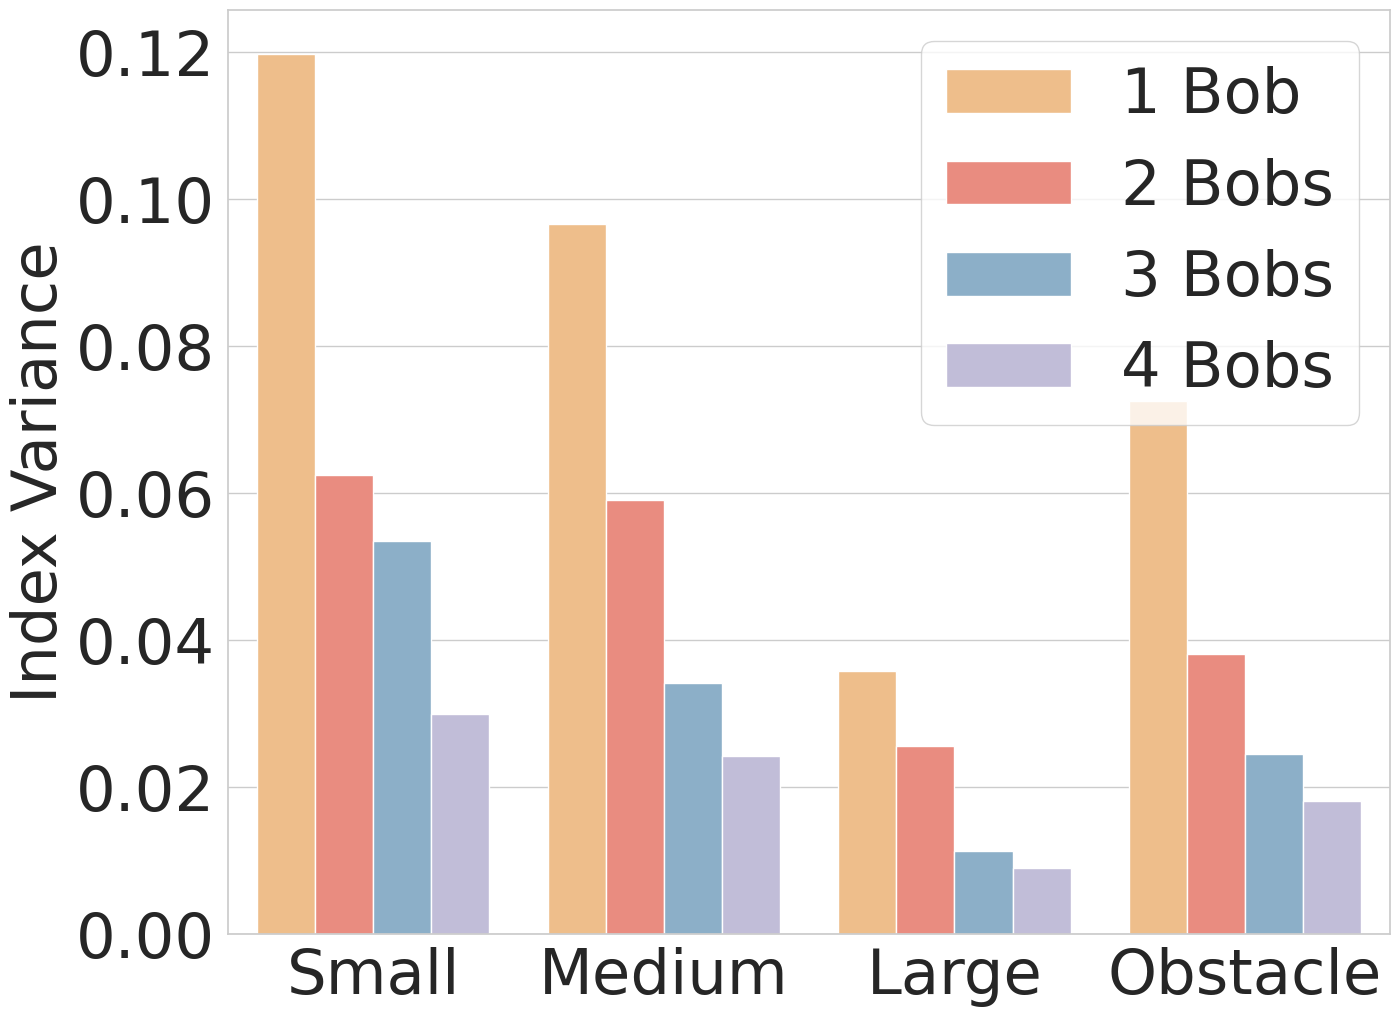

In [21]:
for env in env_name:
    plt.clf()
    temp_df = index_df[index_df['env'] == env]
    ax = sns.barplot(data=temp_df, x='config', y='variance', hue='seeds_num', palette=sns.color_palette(palette,4))

    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('Index Variance', fontsize=fontsize)
    # ax.set_title((env_name.replace('_',' ')+' Tournament').title(), fontsize=fontsize, y=1.05)
    ax.legend(fontsize=fontsize, loc='best')

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.savefig(os.path.join(export_dir, f'index_var_{env}.'+filetype), bbox_inches='tight')

In [22]:
np.shape(method_dict['chicken'])

(4, 5, 4)

In [23]:
comp_df = pd.DataFrame()
seed_num_list = ['1 Bob','2 Bobs','3 Bobs','4 Bobs']
for env in np.arange(len(env_name)): # 4
    for num_seed in np.arange(4): # 4
        mean_diff_list = []
        for sample in np.arange(5): # 5
            temp_comp_df = pd.DataFrame()

            uniform_rewards = np.array([])
            allocated_rewards = np.array([])
            for i in np.arange(len(row_name)):
                method = method_dict[env_name[env]][num_seed][sample][i]
                normalize_factor = np.mean(raw_df.loc[(raw_df['env'] == env_name[env]) & (raw_df['method'] == col_name_dict[col_name[0]]) & (raw_df['config'] == row_name_dict[row_name[i]])]['rewards'].to_numpy())
                
                cur_uniform_rewards = np.sort(raw_df.loc[(raw_df['env'] == env_name[env]) & (raw_df['method'] == 'PP 3 Seeds') & (raw_df['config'] == row_name_dict[row_name[i]])]['rewards'].to_numpy())[-30:]
                cur_allocated_rewards = np.sort(raw_df.loc[(raw_df['env'] == env_name[env]) & (raw_df['method'] == col_name_dict[method]) & (raw_df['config'] == row_name_dict[row_name[i]])]['rewards'].to_numpy())[-30:]
                # if col_name_dict[method] == 'SP':
                #     cur_allocated_rewards = np.sort(np.average(cur_allocated_rewards.reshape(-1, 20), axis=1))[-1]
                uniform_rewards = np.append(uniform_rewards, cur_uniform_rewards/normalize_factor)
                allocated_rewards = np.append(allocated_rewards, cur_allocated_rewards/normalize_factor)
            mean_diff = np.mean(allocated_rewards) - np.mean(uniform_rewards)
            mean_diff_list.append(mean_diff)
        temp_df = pd.DataFrame({'mean_diff': mean_diff_list,
                                'seeds_num': np.repeat(seed_num_list[num_seed], 5),
                                'env': np.repeat(env_name_dict[env_name[env]], 5)})
        comp_df = comp_df._append(temp_df, ignore_index=True) 
comp_df

,mean_diff,seeds_num,env
0,0.036261,1 Bob,Chicken
1,0.030780,1 Bob,Chicken
2,0.040233,1 Bob,Chicken
3,0.040233,1 Bob,Chicken
4,0.030780,1 Bob,Chicken
...,...,...,...
75,0.029691,4 Bobs,Stag\nHunt
76,0.041499,4 Bobs,Stag\nHunt
77,0.017299,4 Bobs,Stag\nHunt
78,0.029691,4 Bobs,Stag\nHunt


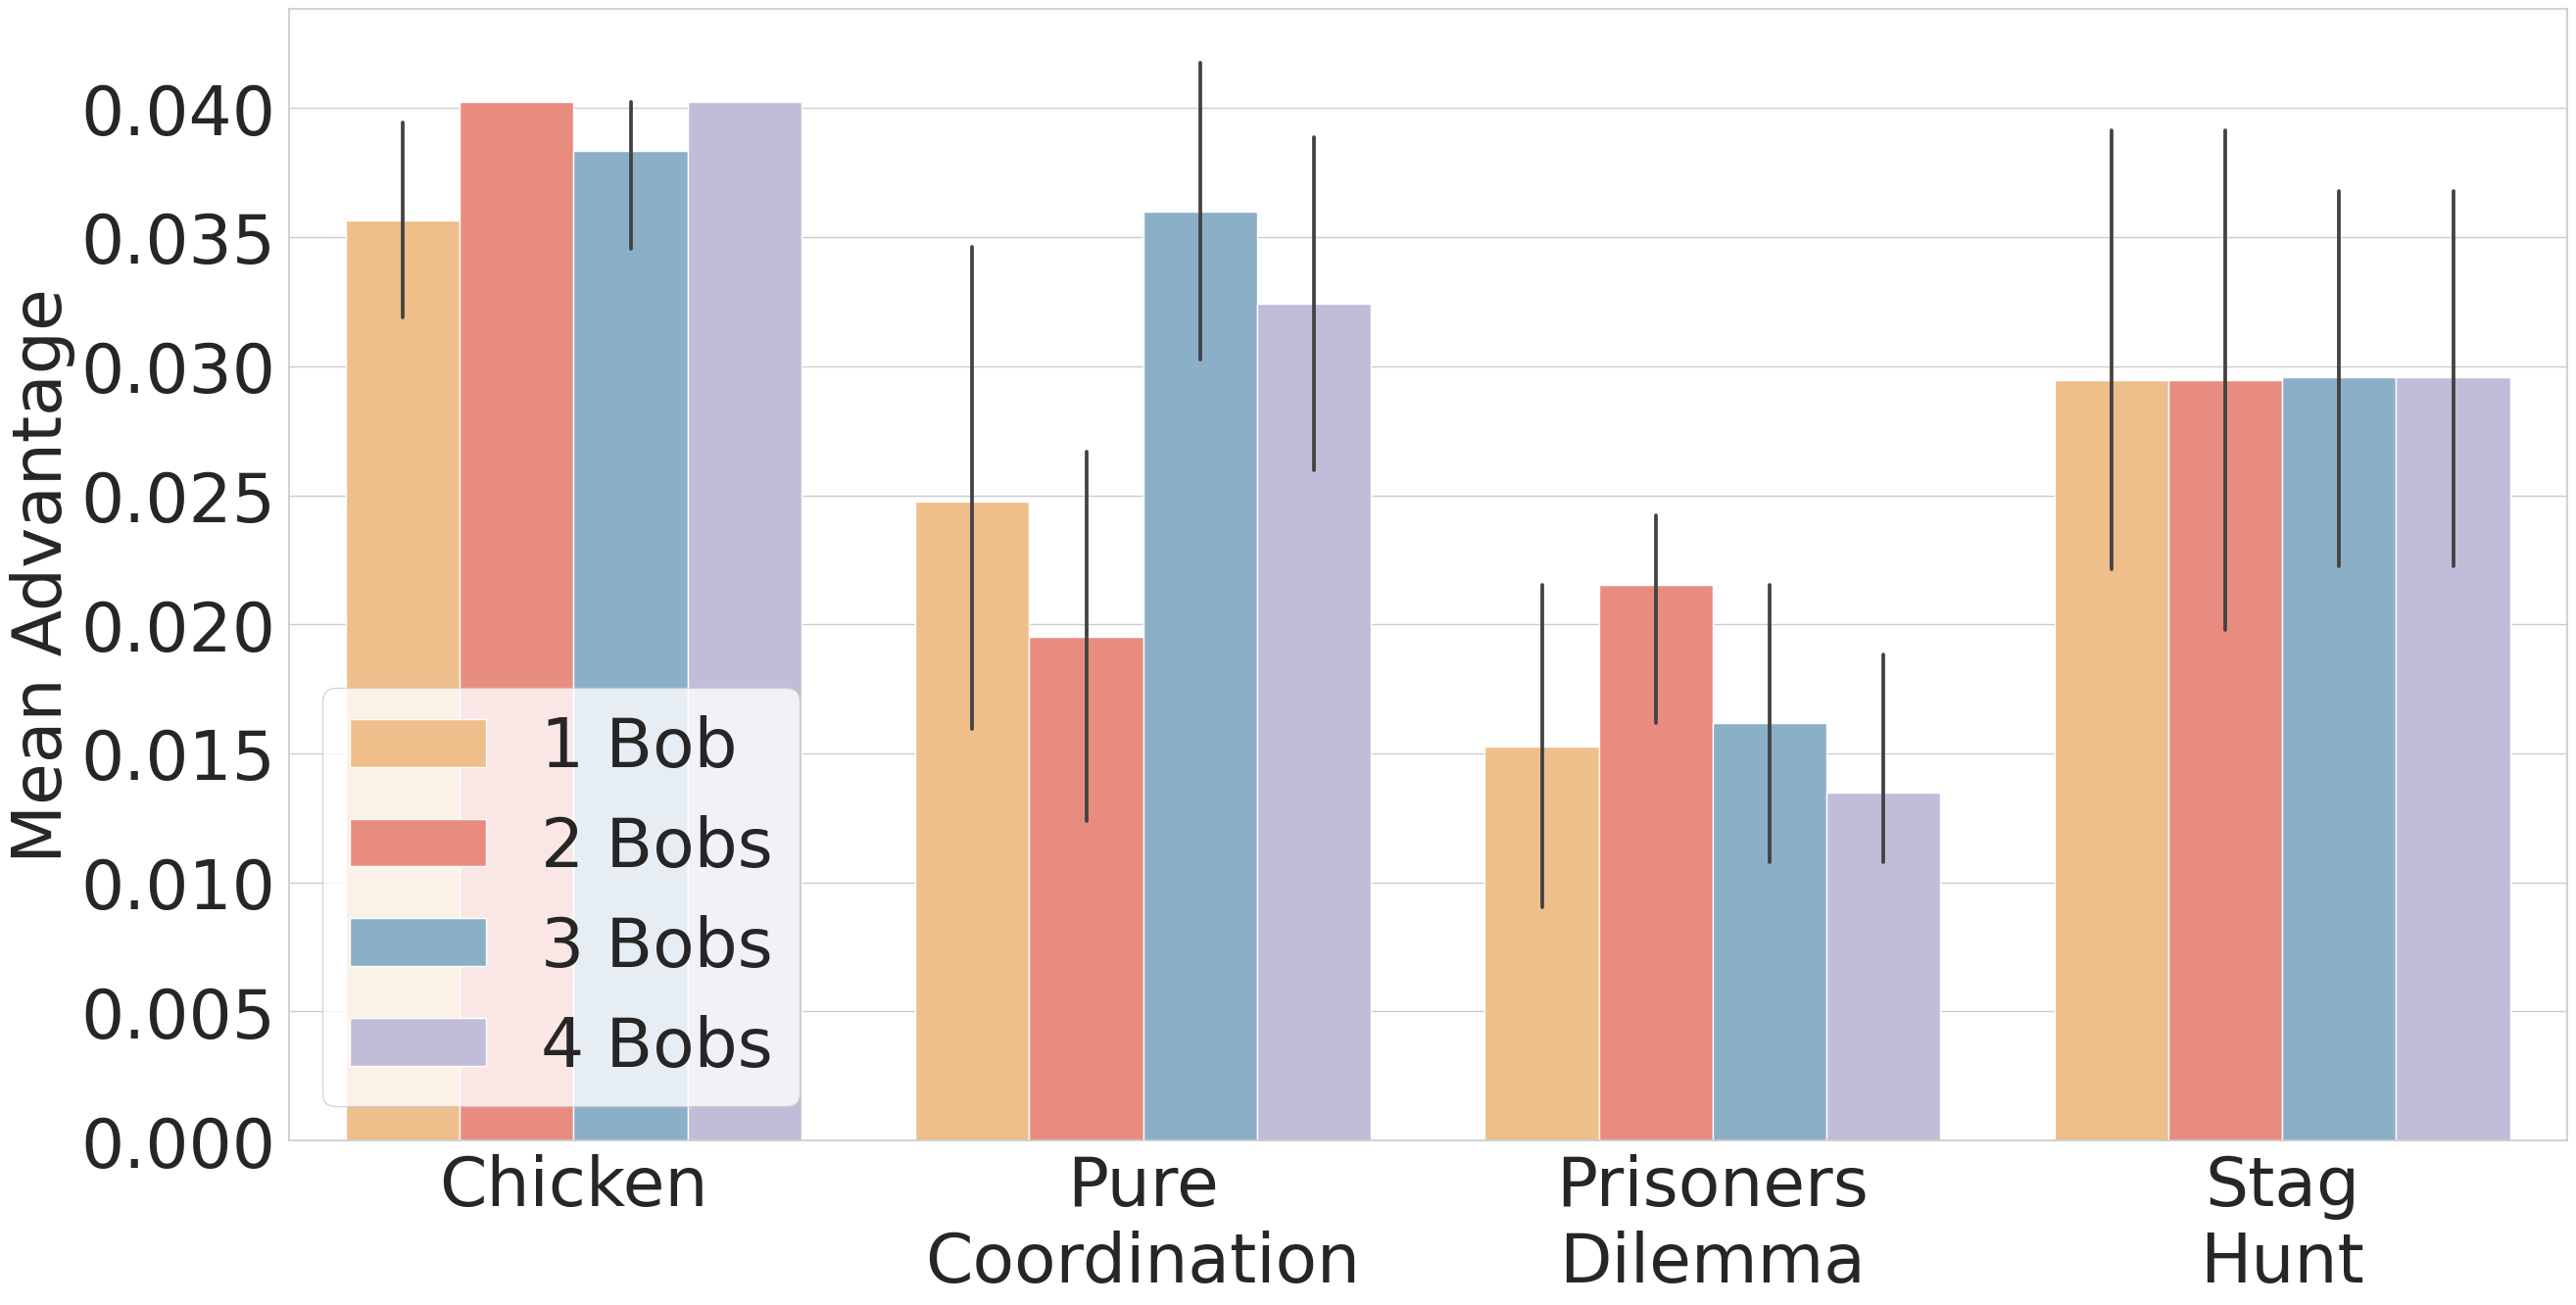

In [24]:
figsize=(30,15)
fontsize = 50
sns.set()
sns.set_context("paper")
sns.set(rc={'figure.figsize':figsize})
sns.set_style("whitegrid")

ax = sns.barplot(data=comp_df, x='env', y='mean_diff', hue='seeds_num', palette=sns.color_palette(palette,4))

ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('Mean Advantage', fontsize=fontsize)
# ax.set_title((env_name.replace('_',' ')+' Tournament').title(), fontsize=fontsize, y=1.05)
ax.legend(fontsize=fontsize, loc='best')

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(export_dir, f'mean_diff.'+filetype), bbox_inches='tight')